<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: SkimLit 🔥
### We will be replicating the deep learning model behind the 2017 paper [PubMed: A Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

**The Problem:** The number of RCT papers releases is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature

**The Solution:** Create a NLP model to classify abstract sentences into the role they play from the list of possible roles (objective, method, result, background or conclusion)

The data comes from: [PubMed: A Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

The model is from: [Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)


### Steps to follow
1. Download the data
2. Perform Pre-processing
3. Create a baseline model

## 1. Dowload the data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 18.29 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


We will use the dataset `PubMed_20k_RCT_numbers_replaced_with_at_sign` for faster iterations on smaller data size. The `PubMed_200k_RCT_numbers_replaced_with_at_sign` is superset of `PubMed_20k_RCT_numbers_replaced_with_at_sign` where all the numbers (numerical values) are replaced with `at-sign`

In [2]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


**dev.txt**: Validation dataset

**train.txt**: Training dataset

**test.txt**: Test dataset

In [3]:
import os
# Lets turn the filepath and the filename to a variable
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# List all the files in a directory
filenames= [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

```
Visualize, Visualize, Visualize
```

In [4]:
# A function to read lines of a target file
from typing import List

def read_lines(filename) -> List[str]:
  """
    Reads a file and returns the lines of the file as list
    Args:
      filename(str): Name of the file
    Returns(List[str]):
      A list containing the lines in the file
  """
  with open(filename,"r") as f:
    return f.readlines()

In [5]:
train_text = read_lines(data_dir+"train.txt")
train_text[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Observations from reading the content of `train.txt`
1. Each sentence is prefixed with _role_ and separated by (`\t`) from the content of the sentence.
2. Each sentence ends with (`\n`) and a comma (`,`)
3. Every abstract is separated by abstract Id which starts with three hash (`###`) followed by a number and ends with (`\n`) and comma (`,`)
4. Every abstract ends with (`\n`) in a line

We will have to write a function such that all the lines in the target file are returned as list of dictionaries containing key/value pairs:
  
  * `"line_number"`: the position of the line in the abstract
  * `"target"`: the role of the line in the abstract
  * `"text"`: the text of the line in the abstract
  * `"total_lines"`: the total lines in an abstract sample

  Example output for a single line in an abstract
  ```
  [
    {
      "line_number":3
      ,"target": "OBJECTIVE"
      ,"text":"It was expected that emotional eating is predictive of elevated attention for food and higher food intake after an experimentally induced sad mood and that attentional maintenance on food predicts food intake during a sad versus a neutral mood ."
      ,"total_lines": 11
    }
    ,{

    }
  ]  
  ```

In [6]:
from typing import Dict,List
def preprocess_text_with_line_numbers(filename) -> List[Dict]:
  """
    Takes a filename and returns the contents of the file as list of dictionaries.
    Args:
      filename(str): The name of the target file
    Returns:
      abstract_lines(List[Dict]): A list of dictionaries each containing a line from the abstract.
      Example output:
        [
          {
            "line_number":3
            ,"target": "OBJECTIVE"
            ,"text":"It was expected that emotional eating is predictive of elevated attention for food and higher food intake after an experimentally induced sad mood and that attentional maintenance on food predicts food intake during a sad versus a neutral mood ."
            ,"total_lines": 11
          }
          ,{
            "line_number":4
            ,"target": "BACKGROUND"
            ,"text":"Emotional eating is associated with overeating and the development of obesity ."
            ,"total_lines": 13
          }
        ]
  """
  # all_abstracts = []
  # abstract_line=""
  # file_content = read_lines(filename)
  # line_number = 0
  # abstract_line = {}
  # for line in file_content:
  #   # Check if the line contains abstract id
  #   if line.startswith("###"):
  #     abstract_id = line
  #   elif line in ['\n']:
  #     abstract_line["total_lines"] = line_number-1
  #     all_abstracts.append(abstract_line)
  #     line_number = 0
  #     abstract_line = {}
  #   else:
  #     target,text = line.split("\t")
  #     line_number += 1
  #     abstract_line["line_number"] = line_number
  #     abstract_line["target"] = target
  #     abstract_line["text"] = text
  # return all_abstracts
  input_lines = read_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [7]:
all_abstracts=preprocess_text_with_line_numbers(data_dir+"train.txt")

In [8]:
len(all_abstracts)

180040

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples),len(test_samples)

CPU times: user 669 ms, sys: 98.6 ms, total: 768 ms
Wall time: 1.01 s


(180040, 30212, 30135)

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
len(train_df),len(val_df), len(test_df)

(180040, 30212, 30135)

In [12]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

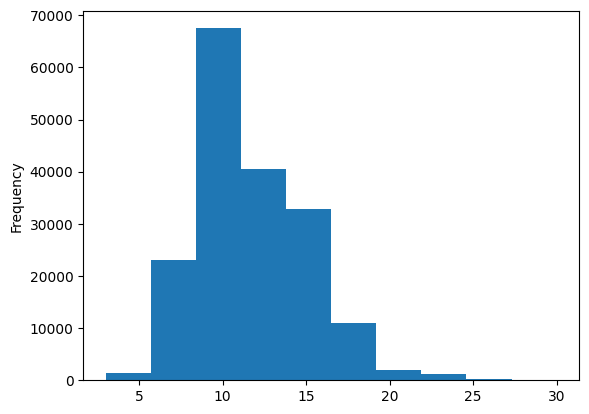

In [13]:
train_df.total_lines.plot.hist();

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

### Make numerical labels
We're going to create one hot and label encoded labels
> We could get away with just making label encoded labels, however, Tensorflow's CategoricalCrossEntropy loss function likes to have one hot encoded labels

In [15]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
## Extract labels ( targets ) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [18]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
num_classes = len(label_encoder.classes_)
classes = label_encoder.classes_
num_classes,classes

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline
Our first model will be a Tf-Idf Multinomial Naive Bayes as recommended by [Scikit-Learn's Machine Learning map](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-0-getting-a-baseline)

To build it we will use Scikit-Learn's `pipeline` which use `TfidfVectorizer` class to convert our abstract sentences into numbers using TF-IDF (term frequency- inverse document frequency) algorithm and then learn's to classify the sentence using `MultinomialNB` algorithm

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer())
    ,("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences
              ,y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

We need to define a function to calculate the following model metrics
1. Accuracy
2. Precision
3. Recall
4. f1-score

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from typing import Dict
def calculate_results(y_true,y_pred)-> Dict:
  """
    Calculate the model evaluation metrics, namely : accuracy, precision, recall, fscore
    Args:
      y_true(List[Any]): True labels
      y_pred(List[Any]): Predicted labels
    Returns:
      model_results(Dict)
  """
  accuracy = accuracy_score(y_true=y_true,y_pred=y_pred) * 100
  # calculate the precision, recall and f1_score using the "weighted" average
  precision,recall,f1_score,_ = precision_recall_fscore_support(y_true=y_true,y_pred=y_pred,average="weighted")
  model_results = {
      "accuracy":accuracy
      ,"precision":precision
      ,"recall":recall
      ,"f1score":f1_score
  }
  return model_results


In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1score': 0.6989250353450294}

### Preparing the data from deep sequence models
Before we embark on the journey of creating model, we will have to _numericalize_ our data using text vectorizer and embedding layers. Hence, we will have to create our own **text vectorizer** and **embedding layer**

In [25]:
# import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Since, we will be dealing with text, its a good practice to find out the length of each line to be used for training.
> _In general, neural networks works best when the inputs are of the same size. This is important as it will be used to create batches of same size
For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as 29 words sentence_.

In [26]:
#Let's find the average length of sentences in our training set
sentence_lengths = [len(sentence.split()) for sentence in train_sentences ]
avg_len = sum(sentence_lengths)/len(train_sentences)
avg_len

26.338269273494777

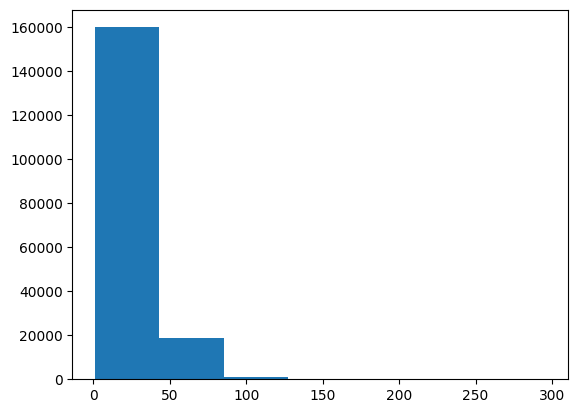

In [27]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths,bins=7);

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sentence_lengths,95))
output_seq_len

55

> **🔑Note**: Good practices to be followed when working with text corpus for a NLP problem
1. What is the length of longest text?
2. What is the length of smallest text?
3. What is the distribution of length of text?
4. One-hot encode the target labels
5. LabelEncode the target labels


In [29]:
# As mentioned in Table.1
max_tokens=68000
#Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens
                                 ,output_sequence_length=55) ## 55 since, we saw that 95% percent of lines in abstract are of length 55

# adapt text vectorizer to training data

text_vectorizer.adapt(train_sentences)


In [30]:
# Test our text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"Length of text:\n {len(target_sentence.split())}")
print(f"Vectorized Text:\n {text_vectorizer([target_sentence])}")

Text:
 for all clinical grades combined , there were no significant differences in the rates of dci ( @ % versus @ % ; p = @ ) or modified rankin scale score of @ to @ at @ months ( @ % versus @ % ; p = @ ) between the @ groups .
Length of text:
 55
Vectorized Text:
 [[  11   62   47 3751  286   61    9   33   37  102    5    2  162    4
  7720  110   14   16  599 3804  158  101    4    6   15   41  110   14
    30    2   24    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [31]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding
Our `text_vectorization` layers maps the words in our text directly to numbers.However, this doesn't capture the context of the sentence or in other words relation between the numbers

To create richer numerical representation of our text, we need to use **embedding**

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationship between tokens (numbers) in our corpus, hence will be able to gain the context of the sentences.

We can create trainable embeddings using Tensorflow's `Embedding` layer.

Again, here we are concerned about the input and output parameters of our `Embedding` layer.

The `input_dim` describes the vocabulary size (68K in our case). And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the output of `text_vectorization` as input and convert them into feature vector of size `output_dim`

In [32]:
# Create token embedding layer
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab)
                               ,output_dim=128
                               ,mask_zero=True
                               ,name="model_0_embedding"
                               )

print(f" Sentence before vectorization:{target_sentence}")
vectorized_text = text_vectorizer([target_sentence])
print(f" Sentence after vectorization before embedding: {vectorized_text}")
trainable_embeddings = token_embed(vectorized_text)
print(f" Sentence after  embedding: {trainable_embeddings}")

 Sentence before vectorization:for all clinical grades combined , there were no significant differences in the rates of dci ( @ % versus @ % ; p = @ ) or modified rankin scale score of @ to @ at @ months ( @ % versus @ % ; p = @ ) between the @ groups .
 Sentence after vectorization before embedding: [[  11   62   47 3751  286   61    9   33   37  102    5    2  162    4
  7720  110   14   16  599 3804  158  101    4    6   15   41  110   14
    30    2   24    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
 Sentence after  embedding: [[[-0.0007387   0.04976698 -0.03102542 ... -0.01413298 -0.02738327
    0.00092121]
  [-0.01731045  0.00407443 -0.04363661 ...  0.04182038 -0.03007948
   -0.01363493]
  [-0.03700279 -0.01869224 -0.04926614 ...  0.00509393  0.01323992
   -0.00526383]
  ...
  [-0.01569391 -0.04233602  0.00924323 ... -0.02976642 -0.01734535
    0.0299186 ]
  [-0.01569391 -0.04233602  0.00924323 ... -0.0

In [33]:
from datetime import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  """
    This function is used as a callback during the training of a model.
    This will store the training experiments as we iterate over various strategies of
    building / training the model
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## Create Datasets

In [34]:
len(train_sentences),len(val_sentences)

(180040, 30212)

In [35]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset= tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset= tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings
All our deep learning models will have a similar structure
```
Text(input) -> Tokenize -> Embedding -> Layers -> Output (Label Probabilities)
```

In [37]:
# Create a 1D convolutional model to process sentences
inputs= layers.Input(shape=(1,),dtype=tf.string)
text_vectors= text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
print(f"Shape of embedding tokens: {token_embeddings.shape}")
x= layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x= layers.GlobalAveragePooling1D()(x)
outputs= layers.Dense(num_classes,activation="softmax")(x)
model_1= tf.keras.Model(inputs,outputs,name="conv1d")

model_1.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

model_1.summary()

Shape of embedding tokens: (None, 55, 128)
Model: "conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 model_0_embedding (Embeddin  (None, 55, 128)          8299648   
 g)                                                              
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                 

Before we fit the model, let us create a function to push save our model experiments so that we can visualize it later on a tensorboard

In [38]:
SAVE_DIR="model_log"

In [39]:
history_1 = model_1.fit(train_dataset
                        ,steps_per_epoch=int(0.1 * len(train_dataset))
                        ,validation_data=val_dataset
                        ,validation_steps=int(0.1*len(val_dataset))
                        ,epochs=5
                        ,callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_1_con1D")]
                        )

Epoch 1/5
562/562 [==============================] - 44s 60ms/step - loss: 0.9225 - accuracy: 0.6379 - val_loss: 0.6845 - val_accuracy: 0.7397
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6590 - accuracy: 0.7561 - val_loss: 0.6326 - val_accuracy: 0.7719
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6178 - accuracy: 0.7762 - val_loss: 0.5945 - val_accuracy: 0.7862
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5878 - accuracy: 0.7894 - val_loss: 0.5769 - val_accuracy: 0.7879
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5898 - accuracy: 0.7931 - val_loss: 0.5591 - val_accuracy: 0.7985


In [40]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5592 - accuracy: 0.8022


[0.5591925382614136, 0.8021978139877319]

In [41]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.5233252e-01, 1.7247899e-01, 4.2901088e-02, 1.7447734e-01,
        5.7810053e-02],
       [4.1349697e-01, 4.0185982e-01, 2.3885993e-02, 1.2096037e-01,
        3.9796878e-02],
       [2.0295899e-01, 4.9064797e-03, 1.4933560e-03, 7.9060483e-01,
        3.6389414e-05],
       ...,
       [3.1036932e-05, 6.2349811e-04, 4.5538358e-03, 2.2755514e-05,
        9.9476886e-01],
       [9.4849959e-02, 2.6634398e-01, 1.2338285e-01, 5.9489626e-02,
        4.5593357e-01],
       [1.6583702e-01, 7.4803191e-01, 5.0119840e-02, 1.4289887e-02,
        2.1721303e-02]], dtype=float32)

In [42]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [43]:
model_1_results = calculate_results(y_true=val_labels_encoded
                                    ,y_pred=model_1_preds)
model_1_results

{'accuracy': 80.21978021978022,
 'precision': 0.8019832926733776,
 'recall': 0.8021978021978022,
 'f1score': 0.7990019722013235}

## Model 2: Feature extraction with pretrained token embeddings
As we move towards replicating the model architecture in [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf), it mentions they have used a [pretrained GLoVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

For our learning purpose , we will use whatever is available from Tensorflow hub. [GLoVe embedding](https://nlp.stanford.edu/projects/glove/) is not available in Tensorflow hub, hence we will use [pretrained Universal Sentence Embedding from Tensorflow hub](https://tfhub.dev/google/universal-sentence-encoder/4)

_This type of model is called **transfer learning**, or more specifically **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem_

In [44]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4"
                                        ,trainable=False
                                        ,name="universal_sentence_encoder")


In [45]:
random_training_sentence= random.choice(train_sentences)
print(f" Training sample sentence: {random_training_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f" Shape of the embedding vector generated use Universal Sentence Encoder : {use_embedding_sentence.shape}")
print(f" Sentence embedding :{use_embedding_sentence[0][:30]}")
print(f" Length of sentence embedding: {len(use_embedding_sentence[0])}")

 Training sample sentence: the aim of this study was to find out whether intermittent preventive treatment ( ipt ) with a fixed-dose combination of mefloquine-artesunate ( mqas ) or sulfadoxine-pyrimethamine plus amodiaquine ( spaq ) was more effective than daily proguanil for malaria prevention in subjects with scd .
 Shape of the embedding vector generated use Universal Sentence Encoder : (1, 512)
 Sentence embedding :[-0.03175477 -0.01098753 -0.0021994  -0.08619042 -0.07472973  0.0320064
 -0.00705428 -0.01710248  0.0466636  -0.00187689  0.08958559 -0.05112983
  0.04827198  0.01623714  0.01998154 -0.00029642 -0.09055552  0.01014399
  0.02262563 -0.02502226  0.06839649 -0.00274909 -0.0716355  -0.04885212
  0.04775355  0.01494818  0.0412404  -0.04814953 -0.06373673 -0.00216345]
 Length of sentence embedding: 512


  Building and fitting an NLP feature extraction model from Tensorflow hub

In [46]:
# Define feature extraction model from Tensorflow hub
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="feature_extraction_model_2")

model_2.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

model_2.summary()

Model: "feature_extraction_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [47]:
history_2 = model_2.fit(train_dataset
                        ,steps_per_epoch=(0.1 * len(train_dataset))
                        ,validation_data=val_dataset
                        ,validation_steps=(0.1 * len(val_dataset))
                        ,epochs=5
                        ,callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="feature_extractor_model_2")]
                        )

Epoch 1/5
562/562 [==============================] - 12s 15ms/step - loss: 0.9143 - accuracy: 0.6472 - val_loss: 0.8040 - val_accuracy: 0.6865
Epoch 2/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7693 - accuracy: 0.7014 - val_loss: 0.7585 - val_accuracy: 0.7030
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7511 - accuracy: 0.7138 - val_loss: 0.7398 - val_accuracy: 0.7158
Epoch 4/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7182 - accuracy: 0.7254 - val_loss: 0.7108 - val_accuracy: 0.7273
Epoch 5/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7245 - accuracy: 0.7216 - val_loss: 0.6916 - val_accuracy: 0.7359


In [48]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6969 - accuracy: 0.7356


[0.6968746185302734, 0.7356017231941223]

In [49]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[6.3943940e-01, 2.2729161e-01, 2.2551334e-03, 1.2112728e-01,
        9.8865889e-03],
       [4.9425444e-01, 4.1122434e-01, 7.7834260e-03, 8.3915688e-02,
        2.8221828e-03],
       [3.5124364e-01, 7.7383935e-02, 5.1905673e-02, 4.7008839e-01,
        4.9378313e-02],
       ...,
       [2.2358298e-03, 2.7054085e-03, 9.1508172e-02, 6.4448628e-04,
        9.0290612e-01],
       [2.3505560e-03, 2.1445304e-02, 5.1417893e-01, 8.6626143e-04,
        4.6115896e-01],
       [1.6438624e-01, 3.7026349e-01, 4.1435745e-01, 2.4368973e-03,
        4.8555873e-02]], dtype=float32)

In [50]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 2])>

In [51]:
model_2_results = calculate_results(y_true=val_labels_encoded
                                    ,y_pred=model_2_preds)
model_2_results

{'accuracy': 73.56017476499404,
 'precision': 0.732349753186396,
 'recall': 0.7356017476499405,
 'f1score': 0.7301224439851033}

## Model 3: Conv1D with character embeddings

 The [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) papers suggests use of a hybrid approach of character and token embeddings.

 **Character embedding** are generated using sequences split into characters whereas **token embedding** is created on sequences split into tokens

In [52]:
# A function to convert sentences into sequence of characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

't h e   a i m   o f   t h i s   s t u d y   w a s   t o   f i n d   o u t   w h e t h e r   i n t e r m i t t e n t   p r e v e n t i v e   t r e a t m e n t   (   i p t   )   w i t h   a   f i x e d - d o s e   c o m b i n a t i o n   o f   m e f l o q u i n e - a r t e s u n a t e   (   m q a s   )   o r   s u l f a d o x i n e - p y r i m e t h a m i n e   p l u s   a m o d i a q u i n e   (   s p a q   )   w a s   m o r e   e f f e c t i v e   t h a n   d a i l y   p r o g u a n i l   f o r   m a l a r i a   p r e v e n t i o n   i n   s u b j e c t s   w i t h   s c d   .'

We will have to create character-level datasets by splitting our sequence dataset into characters

In [53]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [54]:
# Average chars in training dataset
char_size = [len(sentence) for sentence in train_sentences]
avg = sum(char_size)/len(train_sentences)
avg

149.3662574983337

In [55]:
# What is the average number of characters that 95% for sentences have in our training dataset
output_seq_char_length = int(np.percentile(char_size,95))
output_seq_char_length

290

The whole idea of finding out the `output_seq_char_length` is to use the same value for `output_sequence_length` parameter while initializing `TextVectorization`

We will have to set `max_token` parameter value to a value such that it includes
1. Number of characters in english alphabet.
2. Number of digits
3. Number of punctuations
4. Out Of Vocabulary
5. Space character

In [56]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
NUM_CHARS_TOKEN = len(alphabet) +2
NUM_CHARS_TOKEN

70

In [58]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS_TOKEN
                                    ,output_sequence_length=output_seq_char_length
                                    ,standardize="lower_and_strip_punctuation"
                                    ,name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [59]:
# check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f" Number of different characters in character vocab: {len(char_vocab)}")
print(f" 5 most common characters : {char_vocab[:5]}")
print(f" 5 least common characters: {char_vocab[-5:]}")

 Number of different characters in character vocab: 28
 5 most common characters : ['', '[UNK]', 'e', 't', 'i']
 5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [60]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f" Charified text:\n{random_train_chars}")
print(f" Length of chars :{len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f" Vectorized chars :{vectorized_chars}")
print(f" Length of vectorized chars: {len(vectorized_chars[0])}")

 Charified text:
p s y c h o s o c i a l   c o m o r b i d i t y   i n   s o d   i s   h i g h   .
 Length of chars :35
 Vectorized chars :[[14  9 19 11 13  7  9  7 11  4  5 12 11  7 15  7  8 22  4 10  4  3 19  4
   6  9  7 10  4  9 13  4 18 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating character-level embedding
We've got a way to vectorize our character-level sequences, now its time to create character-level embeddings.
Our character-level embedding will need `input_dim` and `output_dim` parameters.
```
input_dim = number of characters in our char_vocab
output_dim = number of ouput dimension mentioned in Figure 1. of paper https://arxiv.org/pdf/1612.05251.pdf
```

In [61]:
char_embed = layers.Embedding(input_dim=len(char_vocab)
                              ,output_dim=25
                              ,mask_zero=False
                              ,name="char_embed")
# char_embed = layers.Embedding(input_dim=NUM_CHARS_TOKEN
#                               ,output_dim=25
#                               ,mask_zero=False
#                               ,name="char_embed")

print(f" Charified text (before vectorization and embedding) :\n{random_train_chars}\n")
char_embed_sample = char_embed(char_vectorizer([random_train_chars]))
print(f" Embedding chars (after vectorization and embedding) :\n{char_embed_sample}\n")
print(f" Character Embedding Shape : {char_embed_sample.shape}")

 Charified text (before vectorization and embedding) :
p s y c h o s o c i a l   c o m o r b i d i t y   i n   s o d   i s   h i g h   .

 Embedding chars (after vectorization and embedding) :
[[[-0.00760788 -0.0291178  -0.0055772  ...  0.03337479 -0.02756327
   -0.01257503]
  [-0.04327319 -0.03998095  0.03922855 ...  0.01519171 -0.03461286
   -0.02168449]
  [ 0.03238448  0.04491978  0.02362527 ...  0.00415416 -0.02346532
   -0.02986017]
  ...
  [-0.0094506   0.00097936 -0.02274281 ... -0.02977016  0.00591602
   -0.00615416]
  [-0.0094506   0.00097936 -0.02274281 ... -0.02977016  0.00591602
   -0.00615416]
  [-0.0094506   0.00097936 -0.02274281 ... -0.02977016  0.00591602
   -0.00615416]]]

 Character Embedding Shape : (1, 290, 25)


### Building a Conv1D model to fit on character embeddings
Now as we have been able to convert character-level sequence into numbers(`char_vectorizer`) as well as numerically represent them as an embedding (`char_model`), let's test how effective they are at encoding the information in our sequence by creating a character-level sequence model

Model Structure:
```
Input (Character-level text) -> Tokenize -> Embedding -> Layers(Conv1D,GlobalMaxPool1D) -> Output (Label Probabilities)
```

In [62]:
# Make Conv1D on chars only
inputs= layers.Input(shape=(1,),dtype=tf.string)
char_vectors= char_vectorizer(inputs)
char_embedding= char_embed(char_vectors)
x= layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embedding)
x= layers.GlobalMaxPool1D()(x)
outputs= layers.Dense(num_classes,activation="softmax")(x)
model_3= tf.keras.Model(inputs,outputs,name="model_3_conv1D_char_embedding")

model_3.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

model_3.summary()


Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model, we'll have to create char-leve `PrefetchDataset`'s

In [63]:
AUTOTUNE = tf.data.AUTOTUNE
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(AUTOTUNE)


In [64]:
history_3 = model_3.fit(train_char_dataset
              ,steps_per_epoch=(0.1*len(train_char_dataset))
              ,validation_data=val_char_dataset
              ,validation_steps=(0.1*len(val_char_dataset))
              ,epochs=5
              ,callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_3_conv1D_char_embed")])

Epoch 1/5
562/562 [==============================] - 6s 7ms/step - loss: 1.2559 - accuracy: 0.4914 - val_loss: 1.0411 - val_accuracy: 0.5855
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9968 - accuracy: 0.6018 - val_loss: 0.9365 - val_accuracy: 0.6352
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9120 - accuracy: 0.6433 - val_loss: 0.8673 - val_accuracy: 0.6678
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8584 - accuracy: 0.6680 - val_loss: 0.8401 - val_accuracy: 0.6793
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8460 - accuracy: 0.6691 - val_loss: 0.8102 - val_accuracy: 0.6905


In [65]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8251 - accuracy: 0.6831


[0.8250702619552612, 0.6830729246139526]

In [66]:
model_3_pred_probs= model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.1429608 , 0.65548426, 0.02813355, 0.16493757, 0.00848383],
       [0.33385366, 0.31648076, 0.00600043, 0.34082353, 0.00284165],
       [0.32854208, 0.21764345, 0.03607963, 0.39539734, 0.02233746],
       ...,
       [0.04059697, 0.04406678, 0.16926056, 0.05720192, 0.6888738 ],
       [0.08697573, 0.19622247, 0.29156446, 0.10403688, 0.32120046],
       [0.45227507, 0.40296173, 0.10459202, 0.03299847, 0.00717271]],
      dtype=float32)

In [67]:
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 0])>

In [68]:
model_3_results = calculate_results(y_true=val_labels_encoded,y_pred=model_3_preds)
model_3_results

{'accuracy': 68.30729511452402,
 'precision': 0.6889967229221179,
 'recall': 0.6830729511452402,
 'f1score': 0.6822176950341737}

## Model 4: Combining pretrained token embeddings + character-level embedding

The Figure 1. in [paper](https://arxiv.org/pdf/1612.05251.pdf) shows the approach of a hybrid token embedding layer.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they created a stacked embedding to represent sequences before passing them to sequence label prediction layer.

For replicating the approach in Figure 1, we're going to go through the following approach
1. Create a token-level model
2. Create a character-level model
3. Combine (using `layers.Concatenate`) the output of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


In [69]:
# Setup the token inputs/model

token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs
                             ,token_output)

#Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs
                            ,char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output
                                                                  ,char_model.output]
                                                                 )

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#Construct the model
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input]
                         ,outputs=output_layer
                         ,name="model_4_token_char_hybrid_embed")

model_4.summary()



Model: "model_4_token_char_hybrid_embed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

In [70]:
model_4.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

Before fitting the model, we need to create datasets. This model requires two inputs, token-level sequence and character-level sequence.

### Combining token and character data into `tf.data.dataset`

In [71]:
## Prepare Train dataset
#input features
train_char_token_X = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
# output labels
train_char_token_y = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# dataset
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_X,train_char_token_y))


## Prepare Validation dataset
#input features
val_char_token_X = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
# output labels
val_char_token_y = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
# dataset
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_X,val_char_token_y))

#prefetch and batch train and validation data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [73]:
history_4 = model_4.fit(train_char_token_dataset
                        ,steps_per_epoch=(0.1 * len(train_char_token_dataset))
                        ,validation_data=val_char_token_dataset
                        ,validation_steps=(0.1 * len(val_char_token_dataset))
                        ,epochs=5
                        ,callbacks=[
                            create_tensorboard_callback(dir_name=SAVE_DIR
                                                        ,experiment_name="model_4_token_char_hybrid")
                            ]
                        )

Epoch 1/5
562/562 [==============================] - 27s 36ms/step - loss: 0.9730 - accuracy: 0.6115 - val_loss: 0.7956 - val_accuracy: 0.6957
Epoch 2/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7921 - accuracy: 0.6940 - val_loss: 0.7144 - val_accuracy: 0.7263
Epoch 3/5
562/562 [==============================] - 19s 33ms/step - loss: 0.7614 - accuracy: 0.7045 - val_loss: 0.6916 - val_accuracy: 0.7378
Epoch 4/5
562/562 [==============================] - 18s 32ms/step - loss: 0.7342 - accuracy: 0.7215 - val_loss: 0.6690 - val_accuracy: 0.7493
Epoch 5/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7415 - accuracy: 0.7163 - val_loss: 0.6560 - val_accuracy: 0.7507


In [74]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6627 - accuracy: 0.7464


[0.6626679301261902, 0.7464252710342407]

In [75]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 18ms/step


array([[5.9274691e-01, 2.1562454e-01, 3.9975061e-03, 1.7941464e-01,
        8.2163559e-03],
       [4.5441547e-01, 4.2127815e-01, 5.2452628e-03, 1.1532705e-01,
        3.7340466e-03],
       [3.6352682e-01, 4.0970892e-02, 6.0012273e-02, 5.0976998e-01,
        2.5720078e-02],
       ...,
       [1.6877108e-04, 1.4191492e-03, 4.6536252e-02, 8.0678939e-05,
        9.5179510e-01],
       [2.9029115e-03, 2.3083609e-02, 4.1679332e-01, 1.3914581e-03,
        5.5582869e-01],
       [2.1386372e-01, 4.7467315e-01, 2.6351416e-01, 8.5406462e-03,
        3.9408416e-02]], dtype=float32)

In [76]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [77]:
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

{'accuracy': 74.64252614855025,
 'precision': 0.743005886073681,
 'recall': 0.7464252614855025,
 'f1score': 0.7405619627003187}

## Model 5: Transfer Learning with pre-trained token embedding + character-leve embedding + positional embedding.

The approach we will take here is pass on our knowledge about the data to the model. This process of applying our knowledge to build features as input to a model is called **feature engineering**

What is meant by _our knowledge_ in this problem statement?
If we look at the training data, the sentences in the abstract appear in a particular sequence. The sequence could be

* `OBJECTIVE`
* `METHODS`
* `METHODS`
* `METHODS`
* `RESULTS`
* `CONCLUSIONS`

Or,
* `BACKGROUND`
* `OBJECTIVE`
* `METHODS`
* `METHODS`
* `METHODS`
* `RESULTS`
* `RESULTS`
* `CONCLUSIONS`
* `CONCLUSIONS`

Hence, can we encode the order of a set of sequences in an abstract?
For example
* `Sentence 1 of 10`
* `Sentence 2 of 10`
* `Sentence 3 of 10`
* `Sentence 4 of 10`
* ...

In [78]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `line_number` and `total_lines` column are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

Since the `line_number` and `total_lines` are already numerical, we could pass them as they are to the model.
But to avoid our model from thinking a line with `line_number=5` is five times greater than a line with `line_number=1`, we'll use one-hot encoding to encode our `line_number` and `total_lines` features.

We will have to use `tf.one_hot` utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array(or tensor) as input and `depth` parameter to determine the size of the tensor.

In order to define the `depth` parameter, we will have to investigate the distribution of `line_number` column

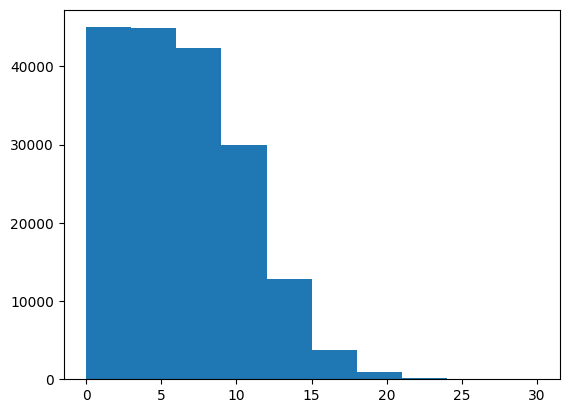

In [79]:
train_df["line_number"].hist(grid=False);

The above graph shows that majority of the lines have position of 15 or less. Hence, this value can be used as value of `depth` parameter in `tf.one_hot` utility

In [80]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Setting the `depth` parameter of `tf.one_hot` to 15 means, any sample with `line_number` over 15 gets transforms to a tensor of all 0's, whereas any sample with `line_number` less than or equal to 15 transforms to tensor with all 0's except 1 at the index equal to value of `line_number`

We used this approach to ensure we limit the number of dimensions

In [81]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

We will have the follow the same procedure for `total_lines` column too.

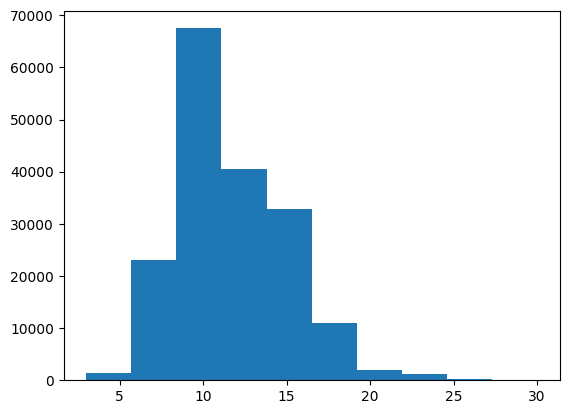

In [82]:
train_df["total_lines"].hist(grid=False);

Looking at the above chart the `depth` parameter for one-hot encoding of `total_lines` can be set to 20

In [83]:
np.percentile(train_df["total_lines"],98)

20.0

In [84]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [85]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building a tribrid embedding model

We will be going through following steps
1. Create a token-level model
2. Create a character-level model
3. Create a line_number model
4. Create a total_lines model
5. Combine using (`tf.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2
6. Combine using (`tf.Concatenate`) the outputs of 3 and 4 and 5 into a token-character-position tribrid embedding.
7. Create an output layer to accept the tribrid embedding and predict label probabilities.
8. Combine the output of 1,2,3,4 and outputs of 7 into a `tf.keras.Model`

In [86]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs
                             ,outputs=token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs
                            ,outputs=char_outputs)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,),dtype=tf.int32,name="line_number_input")
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(inputs=line_number_inputs
                                  ,outputs=x)

# 4. total line inputs
total_lines_inputs= layers.Input(shape=(20,),dtype=tf.int32,name="total_lines_inputs")
x= layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model= tf.keras.Model(inputs=total_lines_inputs
                                  ,outputs=x)

# 5. Combine token and char embeddings into a hybrid embedding
combine_embeddings= layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output
                                                                        ,char_model.output])
z = layers.Dense(256, activation="relu")(combine_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding and token and character embedding into a tribrid embedding
z= layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output
                                                               ,total_lines_model.output
                                                               ,z
                                                               ]
                                                              )

# 7. Create output layer
output_layer= layers.Dense(num_classes, activation="softmax",name="output_layer")(z)

# 8. Put together model
model_5= tf.keras.Model(inputs=[line_number_model.input
                                ,total_lines_model.input
                                ,token_model.input
                                ,char_model.input]
                        ,outputs=output_layer
                        ,name="model_5_tribrid_embedding")



model_5.summary()


Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (to prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample
> 📖 Resource: For more on label smoothing, see the great blog post by PyImageSearch, [Label smoothing with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).

In [87]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )


### Create tribrid embedding datasets.
This time our model needs four feaure inputs.
1. Train line numbers one-hot tensor(`train_line_numbers_one_hot`)
2. Train total numbers one-hot tensor(`train_total_lines_one_hot`)
3. Token-level sequence tensor(`train_sentences`)
4. Char-level sequence tensor(`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices` method to create appropriately shaped and batched `PrefetchedDataset`


In [88]:
# Create training and validation dataset

train_pos_char_token_X = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot
                                                                ,train_total_lines_one_hot
                                                                ,train_sentences
                                                                ,train_chars))

train_pos_char_token_y = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_X
                                                    ,train_pos_char_token_y))
train_pos_char_token_dataset= train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_X = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot
                                                                ,val_total_lines_one_hot
                                                                ,val_sentences
                                                                ,val_chars))

val_pos_char_token_y = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_X
                                                    ,val_pos_char_token_y))
val_pos_char_token_dataset= val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Shape of train and validation dataset
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [89]:
history_5 = model_5.fit(train_pos_char_token_dataset
                       ,steps_per_epoch=(0.1 * len(train_pos_char_token_dataset))
                       ,validation_data=val_pos_char_token_dataset
                       ,validation_steps=(0.1 * len(val_pos_char_token_dataset))
                       ,epochs=5
                       ,callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_4_tribrid_embedding")]
                       )

Epoch 1/5
562/562 [==============================] - 28s 38ms/step - loss: 1.1052 - accuracy: 0.7150 - val_loss: 0.9910 - val_accuracy: 0.8026
Epoch 2/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9705 - accuracy: 0.8122 - val_loss: 0.9523 - val_accuracy: 0.8250
Epoch 3/5
562/562 [==============================] - 19s 34ms/step - loss: 0.9514 - accuracy: 0.8229 - val_loss: 0.9385 - val_accuracy: 0.8345
Epoch 4/5
562/562 [==============================] - 19s 34ms/step - loss: 0.9399 - accuracy: 0.8313 - val_loss: 0.9295 - val_accuracy: 0.8336
Epoch 5/5
562/562 [==============================] - 19s 34ms/step - loss: 0.9362 - accuracy: 0.8368 - val_loss: 0.9231 - val_accuracy: 0.8368


In [90]:
model_5.evaluate(val_pos_char_token_dataset,verbose=1)

945/945 [==============================] - 19s 20ms/step - loss: 0.9225 - accuracy: 0.8413


[0.9225315451622009, 0.8412551283836365]

In [91]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[0.60766387, 0.07676094, 0.01609722, 0.27533066, 0.02414732],
       [0.60338897, 0.087215  , 0.07479891, 0.2188852 , 0.0157119 ],
       [0.38938066, 0.10369007, 0.11142539, 0.34368747, 0.05181641],
       ...,
       [0.026535  , 0.04940328, 0.02914102, 0.02719228, 0.8677284 ],
       [0.0276463 , 0.341737  , 0.12889391, 0.02179434, 0.47992846],
       [0.12197879, 0.69094115, 0.09964114, 0.02289047, 0.06454846]],
      dtype=float32)

In [92]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [93]:
model_5_results = calculate_results(y_true=val_labels_encoded,y_pred=model_5_preds)
model_5_results

{'accuracy': 84.1255130411757,
 'precision': 0.8443198509589633,
 'recall': 0.8412551304117569,
 'f1score': 0.8376148203407758}

### Compare the model results

In [94]:
all_model_results = pd.DataFrame({"baseline":baseline_results
                                  ,"custom_token_embed_conv1d":model_1_results
                                  ,"pretrained_token_embed":model_2_results
                                  ,"custom_char_embed_conv1d":model_3_results
                                  ,"hybrid_char_token_embed":model_4_results
                                  ,"tribrid_pos_char_token_embed":model_5_results
                                  }
                                 )
all_model_results =  all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1score
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.219780,0.801983,0.802198,0.799002
pretrained_token_embed,73.560175,0.732350,0.735602,0.730122
custom_char_embed_conv1d,68.307295,0.688997,0.683073,0.682218
hybrid_char_token_embed,74.642526,0.743006,0.746425,0.740562
tribrid_pos_char_token_embed,84.125513,0.844320,0.841255,0.837615


In [95]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1score
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.802198,0.801983,0.802198,0.799002
pretrained_token_embed,0.735602,0.732350,0.735602,0.730122
custom_char_embed_conv1d,0.683073,0.688997,0.683073,0.682218
hybrid_char_token_embed,0.746425,0.743006,0.746425,0.740562
tribrid_pos_char_token_embed,0.841255,0.844320,0.841255,0.837615


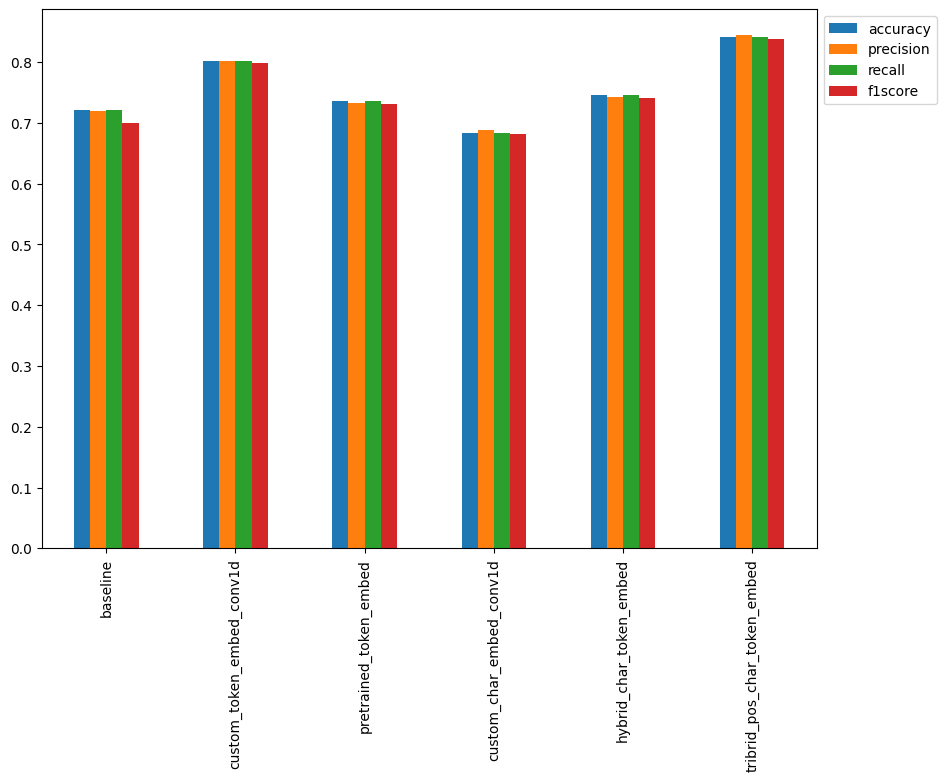

In [105]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

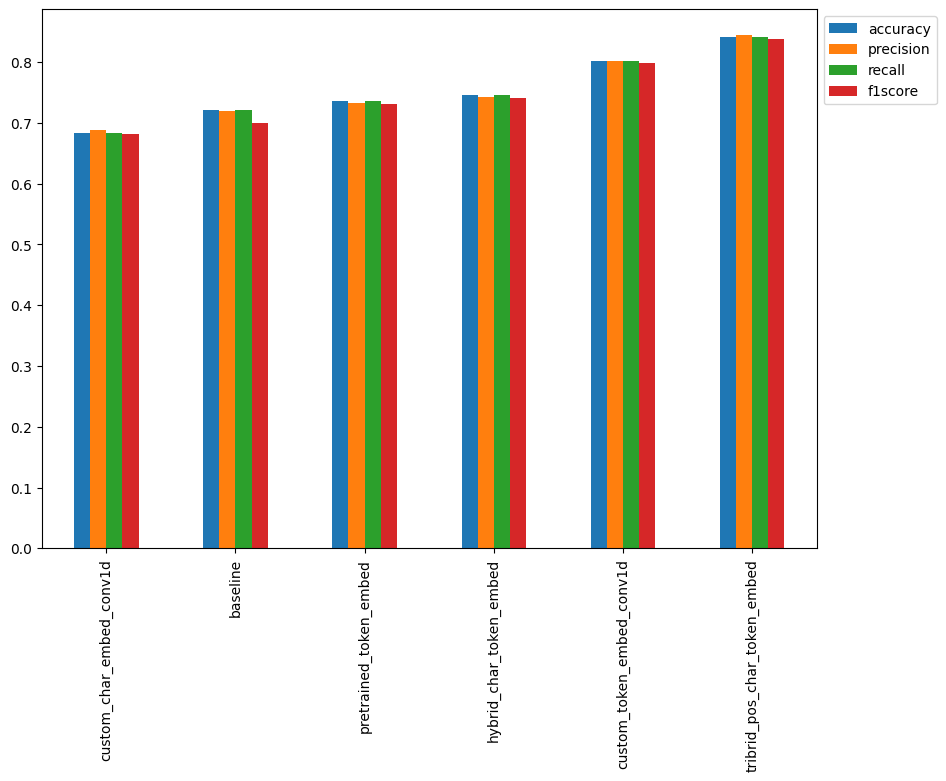

In [108]:
#sort the dataset by f1-score and plot it in ascending order
all_model_results.sort_values("f1score",ascending=True).plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));


## Save and load best performing model

In [109]:
model_5.save("skimlit_tribrid_model")

In [112]:
## Load the saved model
model_path = "/content/skimlit_tribrid_model"
tribrid_hybrid_saved_model = tf.keras.models.load_model(model_path)

# perform prediction using loaded model
loaded_model_pred_probs = tribrid_hybrid_saved_model.predict(val_pos_char_token_dataset,verbose=1)
loaded_model_preds = tf.argmax(loaded_model_pred_probs,axis=1)
loaded_model_preds

945/945 [==============================] - 20s 20ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [113]:
loaded_model_results = calculate_results(y_true=val_labels_encoded
                                         ,y_pred=loaded_model_preds)
loaded_model_results

{'accuracy': 84.1255130411757,
 'precision': 0.8443198509589633,
 'recall': 0.8412551304117569,
 'f1score': 0.8376148203407758}

In [114]:
tribrid_hybrid_saved_model.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

### Evaluate the model on test dataset

In [115]:
# create test dataset batch and prefetched
test_pos_char_token_X = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot
                                                                  ,test_total_lines_one_hot
                                                                  ,test_sentences
                                                                  ,test_chars
                                                                  ))

test_pos_char_token_y = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_X,test_pos_char_token_y))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [116]:
test_pred_probs = tribrid_hybrid_saved_model.predict(test_pos_char_token_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs,axis=1)
tribrid_hybrid_saved_model_test_results = calculate_results(y_true=test_labels_encoded,y_pred=test_preds)
tribrid_hybrid_saved_model_test_results

942/942 [==============================] - 19s 20ms/step


{'accuracy': 83.58719097395056,
 'precision': 0.8386941865872773,
 'recall': 0.8358719097395055,
 'f1score': 0.83218616407766}

## Find the most wrongs

In [117]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

Let's add a few columns to our Dataframe
* A "prediction" (string) column containing our model's prediction for a given sample
* A "pred_prob" (float) column containing the prediction probability associated with a particular prediction
* A "correct" (boolean) column to indicate whether or not the model prediction's matches the true target value for the sample.

In [118]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [120]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs,axis=1).numpy()
test_df["correct"] = test_df["prediction"] ==  test_df["target"]
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.429740,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.452070,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.867650,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.816242,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.650398,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.803374,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.455921,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.474456,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.473944,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.618663,True


In [126]:
top_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob",ascending=False)
top_wrong[:100]

,target,text,line_number,total_lines,prediction,pred_prob,correct
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.952361,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.951109,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.936333,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.931762,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.930968,False
...,...,...,...,...,...,...,...
24263,RESULTS,high-dose and low-dose groups were combined as...,5,15,METHODS,0.857820,False
12456,RESULTS,icd patients were randomized @:@ to automatic ...,1,13,METHODS,0.856620,False
17769,RESULTS,we analyzed @ paired responses ( physicians wi...,5,9,METHODS,0.855926,False
26090,RESULTS,co-primary endpoints were peak change from bas...,2,10,METHODS,0.855625,False


## Make example predictions. Basically collecting abstract from internet and making our model predict the label

The abstract doesn't have the same structure as the data our model was trained on. Hence, we need to preprocess the data before we ask the model to perform prediction.

More specifically,
1. Split it into sentences ( lines )
3. Split the lines into chars
4. Find the line number of each line in an abstract
5. Find the total number of lines in an abstract


In [127]:
import json

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json","r") as f:
  example_abstracts=json.load(f)

example_abstracts

--2023-07-22 01:43:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-07-22 01:43:18 (52.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [128]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [135]:
# 1. Converting the text into lines or sentences
### We will use spaCy to turn big chunk of text into sentences

from spacy.lang.en import English

nlp = English() # Setup English sentence parser

sentencizer = nlp.add_pipe("sentencizer")

doc= nlp(example_abstracts[0]["abstract"])
abstract_lines= [str(sent) for sent in list(doc.sents)]
abstract_lines


['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [136]:
# 2. Calculate the line_numbers and total_lines in abstract
total_lines_in_sample = len(abstract_lines)

sample_lines= []
for i, line in enumerate(abstract_lines):
  sample_dict= {}
  sample_dict["text"]= str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample -1
  sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

Now, we'he got `line_number` and `total_line` values, we can one-hot encode them with `tf.one_hot`.

In [137]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers,depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [138]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines,depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [147]:
# 3. Create chars from sentence

abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [149]:
%%time
test_abstract_pred_probs= tribrid_hybrid_saved_model.predict(x=(test_abstract_line_numbers_one_hot
                                                                ,test_abstract_total_lines_one_hot
                                                                ,tf.constant(abstract_lines)
                                                                ,tf.constant(abstract_chars)
                                                              )
                                                             )
test_abstract_pred_probs


1/1 [==============================] - 2s 2s/step
CPU times: user 1.85 s, sys: 7.75 ms, total: 1.85 s
Wall time: 2.16 s


array([[0.33977348, 0.09580021, 0.02677854, 0.49049422, 0.04715359],
       [0.06208196, 0.03342588, 0.77406615, 0.08469892, 0.04572713],
       [0.08703389, 0.04054566, 0.7220846 , 0.10051376, 0.04982211],
       [0.08276316, 0.13011041, 0.5659268 , 0.0630487 , 0.15815091],
       [0.04689587, 0.09984539, 0.4395532 , 0.0433139 , 0.3703917 ],
       [0.04251693, 0.10386152, 0.56433743, 0.04234508, 0.24693903],
       [0.03140882, 0.2753011 , 0.11623736, 0.02578332, 0.5512694 ],
       [0.01805054, 0.14877374, 0.29773328, 0.03240536, 0.50303704]],
      dtype=float32)

In [150]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs,axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [151]:
test_abstract_pred_classes= [label_encoder.classes_[pred] for pred in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [152]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
